# 

In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [3]:
from lib.cgamma_biweight_log_mpe_prob import c_multi_gamma_biweight_mpe_logprob, postjitter_c_mpe_biweight
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_midpoint, c_multi_gamma_mpe_prob_pure_jax
from lib.cgamma import c_multi_gamma_sf, c_multi_gamma_prob, c_multi_gamma_mpe_prob, postjitter_c_multi_gamma_mpe_prob

In [4]:
convolved_mpe_biweight_v1d_x = jax.jit(jax.vmap(c_multi_gamma_biweight_mpe_logprob, (0, None, None, None, None, None), 0))
convolved_mpe_biweight_postjitter_v1d_x = jax.jit(jax.vmap(postjitter_c_mpe_biweight, (0, None, None, None, None, None, None), 0))
convolved_post_mpe_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint, (0, None, None, None, None, None), 0))
convolved_post_mpe_exact_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, (0, None, None, None, None, None), 0))
convolved_cgamma_sf_v1d_x = jax.jit(jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0))
convolved_cgamma_prob_v1d_x = jax.jit(jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0))
convolved_cgamma_mpe_prob_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob, (0, None, None, None, None, None, None), 0))
convolved_postjitter_cgamma_mpe_prob_v1d_x = jax.jit(jax.vmap(postjitter_c_multi_gamma_mpe_prob, (0, None, None, None, None, None, None), 0))


In [13]:
dist = 10
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[1.15534134 3.76605356 1.00011428] [0.03971155 1.00413749 0.00229017]


In [14]:
@jax.jit
def convolved_cgamma_mpe_prob(x, mix_probs, a, b, n, sigma=3.0):
    probs = convolved_cgamma_prob_v1d_x(x, mix_probs, a, b, jnp.array(3.0), jnp.array(0.1))
    sfs_pn = jnp.power(convolved_cgamma_sf_v1d_x(x, mix_probs, a, b, jnp.array(3.0)), n-1)
    ys = n * probs * sfs_pn
    return ys
    

# 

[nan nan nan nan nan nan nan nan nan nan]
[2.24931657e-31 2.25915446e-31 2.26903504e-31 2.27895849e-31
 2.28892499e-31 2.29893472e-31 2.30898789e-31 2.31908466e-31
 2.32922523e-31 2.33940979e-31]
[9.02187060e-25 9.04641608e-25 9.07102770e-25 9.09570564e-25
 9.12045008e-25 9.14526120e-25 9.17013917e-25 9.19508418e-25
 9.22009640e-25 9.24517601e-25]
[9.18634308e-25 9.21134381e-25 9.23641193e-25 9.26154762e-25
 9.28675107e-25 9.31202245e-25 9.33736195e-25 9.36276975e-25
 9.38824603e-25 9.41379097e-25]
[1.05012090e-24 1.05298641e-24 1.05585967e-24 1.05874070e-24
 1.06162951e-24 1.06452614e-24 1.06743059e-24 1.07034289e-24
 1.07326306e-24 1.07619113e-24]
[6.47309254e-18 6.48608135e-18 6.49909582e-18 6.51213600e-18
 6.52520194e-18 6.53829369e-18 6.55141131e-18 6.56455483e-18
 6.57772432e-18 6.59091982e-18]


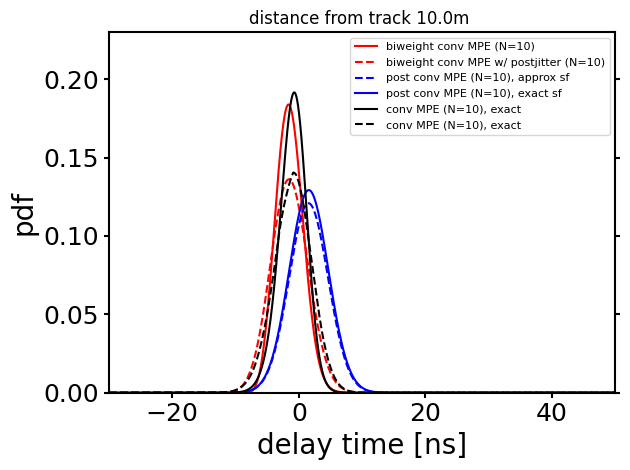

In [18]:
from matplotlib.pyplot import cm

n_p = 10

fig, ax = plt.subplots()
xvals = np.linspace(-30, 50, 100000)

y_max = 0
ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

y_max = 0
ys = convolved_mpe_biweight_postjitter_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'biweight conv MPE w/ postjitter (N={n_p:.0f})', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

#ys = convolved_cgamma_mpe_prob(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
ys = convolved_cgamma_mpe_prob_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(10.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_postjitter_cgamma_mpe_prob_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])


plot_args = {'xlim':[-30, 50],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [16]:
print(xvals.shape)

(100000,)


[nan nan nan nan nan nan nan nan nan nan]
[1.11951993e-29 1.12625671e-29 1.13303370e-29 1.13985115e-29
 1.14670928e-29 1.15360835e-29 1.16054860e-29 1.16753026e-29
 1.17455359e-29 1.18161883e-29]
[1.02427660e-23 1.02806074e-23 1.03185873e-23 1.03567060e-23
 1.03949642e-23 1.04333623e-23 1.04719008e-23 1.05105802e-23
 1.05494012e-23 1.05883640e-23]
[1.18146761e-23 1.18583540e-23 1.19021918e-23 1.19461900e-23
 1.19903493e-23 1.20346702e-23 1.20791532e-23 1.21237991e-23
 1.21686084e-23 1.22135817e-23]
[5.25060450e-23 5.27031489e-23 5.29009857e-23 5.30995582e-23
 5.32988691e-23 5.34989211e-23 5.36997169e-23 5.39012592e-23
 5.41035509e-23 5.43065947e-23]
[3.23654627e-16 3.24547938e-16 3.25443677e-16 3.26341850e-16
 3.27242463e-16 3.28145524e-16 3.29051038e-16 3.29959012e-16
 3.30869453e-16 3.31782367e-16]


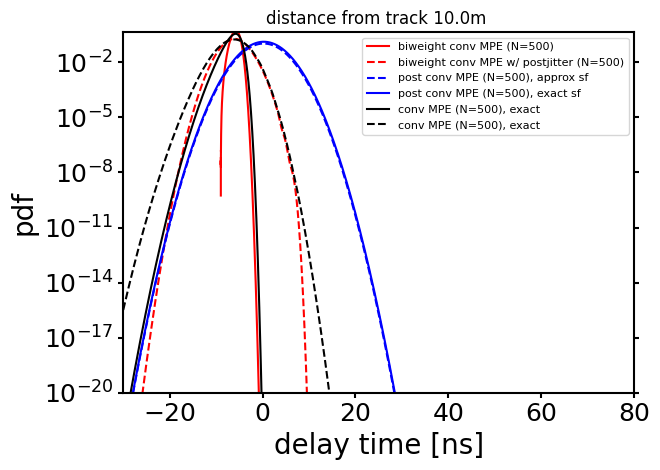

In [17]:
from matplotlib.pyplot import cm

n_p = 500

fig, ax = plt.subplots()
xvals = np.linspace(-30, 80, 100000)

y_max = 0
ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

y_max = 0
ys = convolved_mpe_biweight_postjitter_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'biweight conv MPE w/ postjitter (N={n_p:.0f})', color='red', linestyle='dashed')
y_max =np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_cgamma_mpe_prob_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(10.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_postjitter_cgamma_mpe_prob_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])



plot_args = {'xlim':[-30, 80],
                     'ylim':[1.e-20, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
ax.set_yscale('log')
plt.show()

In [ ]:
%timeit jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))

In [ ]:
%timeit convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

In [ ]:
%timeit convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

In [ ]:
%timeit convolved_cgamma_mpe_prob(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

In [ ]:
convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

In [ ]:
from matplotlib.pyplot import cm

n_p = 50

fig, ax = plt.subplots()
xvals = np.linspace(-30, 50, 100000)

y_max = 0
ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_mpe_biweight_postjitter_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'biweight conv MPE w/ postjitter (N={n_p:.0f})', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_cgamma_mpe_prob(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])



plot_args = {'xlim':[-30, 50],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.axvline(-15)
plt.axvline(-12, color='orange')
plt.axvline(-5, color='orange')
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

### np 5000 at 1m gives peak at ~ -10ns.


In [ ]:
from matplotlib.pyplot import cm

n_p = 5000

fig, ax = plt.subplots()
xvals = np.linspace(-30, 50, 100000)

y_max = 0
ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_mpe_biweight_postjitter_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'biweight conv MPE w/ postjitter (N={n_p:.0f})', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_cgamma_mpe_prob(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])



plot_args = {'xlim':[-30, 50],
                     'ylim':[1.e-40, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.axvline(-15)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
ax.set_yscale('log')
plt.show()